In [38]:
import pandas as pd
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sb
import matplotlib.pyplot as plt
import math
import sys
sys.path.append('/Users/alenastern/Documents/Spring2018/Machine_Learning/Machine_Learning_Public_Policy/hws/hw2')
import numpy as np
import explore as ex
import preprocess as pp
import getfeatures as gf
import evalmodel as em
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read in Data

In [39]:
outcomes = ex.read_data("data/outcomes.csv")
projects = ex.read_data("data/projects.csv")

In [40]:
projects['date_posted'] = pd.to_datetime(projects['date_posted'])

In [4]:
outcomes.head()

,projectid,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
0,ffffc4f85b60efc5b52347df489d0238,f,NaN,f,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN
1,ffffac55ee02a49d1abc87ba6fc61135,f,f,t,t,f,t,f,f,57.0,0.0,7.0
2,ffff97ed93720407d70a2787475932b0,f,f,t,t,t,t,t,f,100.0,0.0,3.0
3,ffff418bb42fad24347527ad96100f81,f,f,f,t,t,f,f,f,100.0,0.0,1.0
4,ffff2d9c769c8fb5335e949c615425eb,t,t,t,t,t,f,t,f,63.0,6.0,2.0


In [41]:
outcomes = outcomes[['projectid', 'fully_funded']]

In [42]:
X = projects[(projects['date_posted'].dt.year >= 2011) & (projects['date_posted'].dt.year <= 2013)]

In [43]:
Y = outcomes[outcomes['projectid'].isin(X['projectid'])]

In [50]:
total_data = pd.merge(X, Y, on = 'projectid')

In [51]:
colnames = ['fully_funded', 'school_charter', 'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp', 'school_charter_ready_promise', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'eligible_double_your_impact_match', 'eligible_almost_home_match']
for col in colnames:
    
    mask = total_data[col] == 'f'
    column_name = col
    total_data.loc[mask, col] = 0
    
    mask = total_data[col] == 't'
    column_name = col
    total_data.loc[mask, col] = 1

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,fully_funded
0,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,Elgin School District U-46,Du Page,0,0,0,0,0,0,Mrs.,0,0,Special Needs,Special Needs,Literacy,Literacy & Language,Other,moderate poverty,Grades 3-5,30.0,444.36,522.78,7.0,0,0,2013-12-31,1
1,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,Idaho Falls School District 91,Bonneville,0,0,0,0,0,0,Mrs.,0,0,Mathematics,Math & Science,NaN,NaN,Supplies,high poverty,Grades 3-5,30.0,233.24,274.40,30.0,0,0,2013-12-31,0
2,1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,School Administrative Unit 10,Rockingham,0,0,0,0,0,0,Mrs.,0,0,Environmental Science,Math & Science,Applied Sciences,Math & Science,Technology,moderate poverty,Grades 6-8,30.0,285.09,335.40,230.0,0,0,2013-12-31,0
3,33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,Richmond City School District,Richmond City,0,0,0,0,0,0,Ms.,0,0,Literacy,Literacy & Language,NaN,NaN,Other,highest poverty,Grades PreK-2,30.0,232.94,274.05,18.0,0,0,2013-12-31,0
4,e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,Ravenswood-ridge Elem Network,Cook,0,1,0,0,0,0,Mr.,0,0,Environmental Science,Math & Science,NaN,NaN,Supplies,highest poverty,Grades 6-8,30.0,513.41,604.01,70.0,1,0,2013-12-31,1


# Explore Data

In [52]:
total_data['month'] = total_data['date_posted'].dt.month

In [53]:
total_data = gf.cat_to_dummy(total_data, ['school_metro','month', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject',
                                          'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'school_state', 'grade_level'])
                                        
                                          

In [54]:
total_data.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,fully_funded,month,school_metro_rural,school_metro_suburban,school_metro_urban,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,primary_focus_subject_Applied Sciences,primary_focus_subject_Character Education,primary_focus_subject_Civics & Government,primary_focus_subject_College & Career Prep,primary_focus_subject_Community Service,primary_focus_subject_ESL,primary_focus_subject_Early Development,primary_focus_subject_Economics,primary_focus_subject_Environmental Science,primary_focus_subject_Extracurricular,primary_focus_subject_Foreign Languages,primary_focus_subject_Gym & Fitness,primary_focus_subject_Health & Life Science,primary_focus_subject_Health & Wellness,primary_focus_subject_History & Geography,primary_focus_subject_Literacy,primary_focus_subject_Literature & Writing,primary_focus_subject_Mathematics,primary_focus_subject_Music,primary_focus_subject_Nutrition,primary_focus_subject_Other,primary_focus_subject_Parent Involvement,primary_focus_subject_Performing Arts,primary_focus_subject_Social Sciences,primary_focus_subject_Special Needs,primary_focus_subject_Sports,primary_focus_subject_Visual Arts,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,secondary_focus_subject_Applied Sciences,secondary_focus_subject_Character Education,secondary_focus_subject_Civics & Government,secondary_focus_subject_College & Career Prep,secondary_focus_subject_Community Service,secondary_focus_subject_ESL,secondary_focus_subject_Early Development,secondary_focus_subject_Economics,secondary_focus_subject_Environmental Science,secondary_focus_subject_Extracurricular,secondary_focus_subject_Foreign Languages,secondary_focus_subject_Gym & Fitness,secondary_focus_subject_Health & Life Science,secondary_focus_subject_Health & Wellness,secondary_focus_subject_History & Geography,secondary_focus_subject_Literacy,secondary_focus_subject_Literature & Writing,secondary_focus_subject_Mathematics,secondary_focus_subject_Music,secondary_focus_subject_Nutrition,secondary_focus_subject_Other,secondary_focus_subject_Parent Involvement,secondary_focus_subject_Performing Arts,secondary_focus_subject_Social Sciences,secondary_focus_subject_Special Needs,secondary_focus_subject_Sports,secondary_focus_subject_Visual Arts,secondary_focus_area_Applied Learning,secondary_focus_area_Health & Sports,secondary_focus_area_History & Civics,secondary_focus_area_Literacy & Language,secondary_focus_area_Math & Science,secondary_focus_area_Music & The Arts,secondary_focus_area_Special Needs,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2,school_state_AK,school_state_AL,school_state_AR,school_state_AZ,school_state_CA,school_state_CO,school_state_CT,school_state_DC,school_state_DE,school_state_FL,school_state_GA,school_state_HI,school_state_IA,school_state_ID,school_state_IL,school_state_IN,school

In [56]:
total_data = pp.drop_vars(total_data, ["school_suburban", 'primary_focus_subject', 'month', 'primary_focus_area', 'secondary_focus_area',
                          'secondary_focus_subject', 'resource_type', 'poverty_level', 'grade_level', 'teacher_acctid', 'schoolid', 
                          'school_ncesid', 'school_latitude', 'school_longitude', 'school_city', 'school_zip', 'school_district',
                          'school_county', 'projectid', 'grade_level'])

In [57]:
ex.dist_table(total_data)

,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_teach_for_america,teacher_ny_teaching_fellow,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,fully_funded,school_metro_rural,school_metro_suburban,school_metro_urban,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,primary_focus_subject_Applied Sciences,primary_focus_subject_Character Education,primary_focus_subject_Civics & Government,primary_focus_subject_College & Career Prep,primary_focus_subject_Community Service,primary_focus_subject_ESL,primary_focus_subject_Early Development,primary_focus_subject_Economics,primary_focus_subject_Environmental Science,primary_focus_subject_Extracurricular,primary_focus_subject_Foreign Languages,primary_focus_subject_Gym & Fitness,primary_focus_subject_Health & Life Science,primary_focus_subject_Health & Wellness,primary_focus_subject_History & Geography,primary_focus_subject_Literacy,primary_focus_subject_Literature & Writing,primary_focus_subject_Mathematics,primary_focus_subject_Music,primary_focus_subject_Nutrition,primary_focus_subject_Other,primary_focus_subject_Parent Involvement,primary_focus_subject_Performing Arts,primary_focus_subject_Social Sciences,primary_focus_subject_Special Needs,primary_focus_subject_Sports,primary_focus_subject_Visual Arts,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,secondary_focus_subject_Applied Sciences,secondary_focus_subject_Character Education,secondary_focus_subject_Civics & Government,secondary_focus_subject_College & Career Prep,secondary_focus_subject_Community Service,secondary_focus_subject_ESL,secondary_focus_subject_Early Development,secondary_focus_subject_Economics,secondary_focus_subject_Environmental Science,secondary_focus_subject_Extracurricular,secondary_focus_subject_Foreign Languages,secondary_focus_subject_Gym & Fitness,secondary_focus_subject_Health & Life Science,secondary_focus_subject_Health & Wellness,secondary_focus_subject_History & Geography,secondary_focus_subject_Literacy,secondary_focus_subject_Literature & Writing,secondary_focus_subject_Mathematics,secondary_focus_subject_Music,secondary_focus_subject_Nutrition,secondary_focus_subject_Other,secondary_focus_subject_Parent Involvement,secondary_focus_subject_Performing Arts,secondary_focus_subject_Social Sciences,secondary_focus_subject_Special Needs,secondary_focus_subject_Sports,secondary_focus_subject_Visual Arts,secondary_focus_area_Applied Learning,secondary_focus_area_Health & Sports,secondary_focus_area_History & Civics,secondary_focus_area_Literacy & Language,secondary_focus_area_Math & Science,secondary_focus_area_Music & The Arts,secondary_focus_area_Special Needs,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2,school_state_AK,school_state_AL,school_state_AR,school_state_AZ,school_state_CA,school_state_CO,school_state_CT,school_state_DC,school_state_DE,school_state_FL,school_state_GA,school_state_HI,school_state_IA,school_state_ID,school_state_IL,school_state_IN,school_state_KS,school_state_KY,school_state_LA,school_state_MA,school_state_MD,school_state_ME,school_state_MI,school_state_MN,school_state_MO,school_state_MS,school_state_MT,school_state_NC,school_state_ND,school_state_NE,school_state_NH,school_state_NJ,school_state_NM,school_state_NV,school_state_NY,school_state_OH,schoo

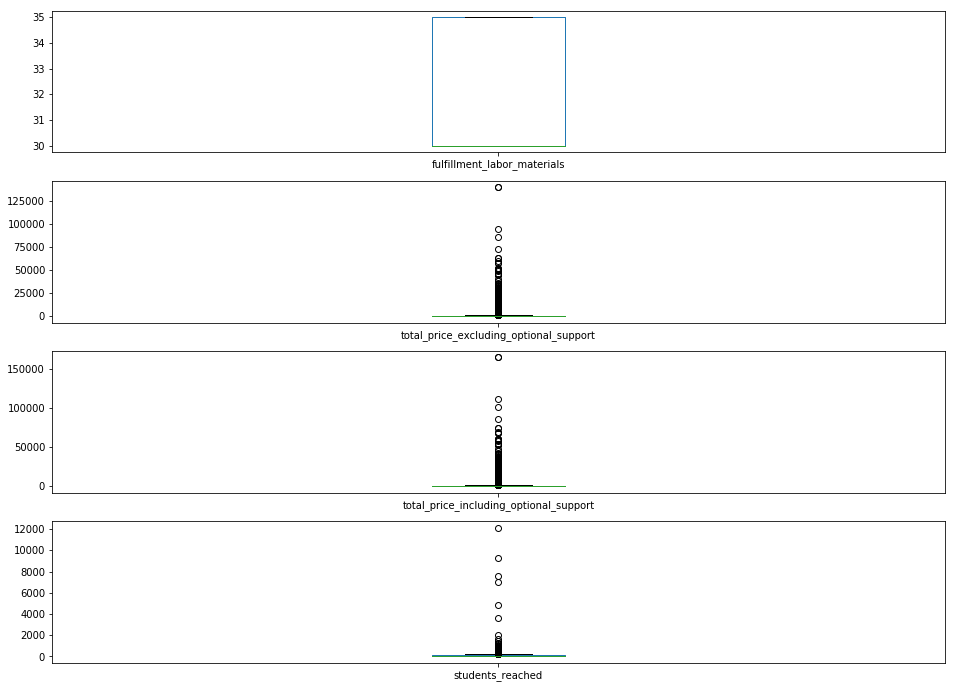

In [58]:
continuous_vars = ['fulfillment_labor_materials','total_price_excluding_optional_support', 
                   'total_price_including_optional_support', 'students_reached']

continuous_data = total_data[continuous_vars]

ex.outliers_plot(continuous_data)

In [ ]:
ex.plot_by_class(total_data, "fully_funded")

KeyboardInterrupt: 

In [ ]:
corr_table = ex.corr_table(total_data)
ex.plot_y_corr(corr_table, "fully_funded")

In [ ]:
ex.plot_corr_matrix(corr_table)